In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from statsmodels.tsa.api import VAR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN

In [2]:
data = pd.read_csv("dataset/timeseries.csv")
data

Year  Temperature  Annual CO2 Emissions  Annual MH4 Emissions   
0   1961     0.163053          2.779522e+10          1.521873e+10  \
1   1962    -0.013476          2.877933e+10          1.550482e+10   
2   1963    -0.006043          3.032081e+10          1.591023e+10   
3   1964    -0.070059          3.194596e+10          1.627464e+10   
4   1965    -0.247027          3.339014e+10          1.675168e+10   
..   ...          ...                   ...                   ...   
57  2018     1.302113          1.078831e+11          3.058126e+10   
58  2019     1.443061          1.086966e+11          3.089436e+10   
59  2020     1.552038          1.038568e+11          3.104839e+10   
60  2021     1.343531          1.092707e+11          3.145000e+10   
61  2022     1.382113                   NaN                   NaN   

    Annual NiO Emissions  
0           4.045673e+09  
1           4.181061e+09  
2           4.315127e+09  
3           4.467189e+09  
4           4.639234e+09  
..                   ...  
57          8.605265e+09  
58          8.649985e+09  
59          8.744636e+09  
60          8.897455e+09  
61                   NaN  

[62 rows x 5 columns]

In [3]:
# Drop the last row from the DataFrame
last_row_index = data.index[-1]
data = data.drop(index=last_row_index)

In [4]:
features = ['Annual CO2 Emissions','Annual MH4 Emissions','Annual NiO Emissions']
target = ['Temperature']

In [5]:
X = data[features].values  # Input features
y = data[target].values  # Target variable

In [6]:
# Normalize the input features using MinMaxScaler on the entire dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Define a list of lags to test
LAGS = [1, 2, 3, 4, 5]

In [8]:
# storage for models in different lags
MODELS_DICT = {
    'VAR': [],
    'RF': [],
    'LSTM': [],
    'RNN': [],
    'SVR': [],
}

In [9]:
MODELS_DICT = {
    'VAR': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
    'RF': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
    'LSTM': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
    'RNN': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
    'SVR': {
        'models': [],
        'mse': [],
        'rmse': [],
        'lags': []
    },
}

In [10]:
def run_algorithm(model_name):
    
    fig, ax = plt.subplots(len(LAGS), 1, figsize=(10, 20))

    for lag in LAGS:
        X_lagged = np.zeros((len(X_scaled) - lag, lag * X_scaled.shape[1]))
        y_lagged = np.zeros(len(y) - lag)

        for i in range(lag, len(X_scaled)):
            X_lagged[i - lag] = X_scaled[i - lag:i].flatten()
            y_lagged[i - lag] = y[i]

        X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, shuffle=False)

        if model_name == "VAR":
            model = VAR(np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1))
            results = model.fit(maxlags=lag)
            lagged_endog_test = np.concatenate((X_test[-lag:], y_test[-lag:].reshape(-1, 1)), axis=1)

            y_pred_train = results.fittedvalues[:, -1]
            y_pred_test = results.forecast(y=lagged_endog_test, steps=len(y_test))[:, -1]
            
            # Calculate MSE and create plots
            mse_train = mean_squared_error(y_train[lag:], y_pred_train)
            rmse_train = np.sqrt(mse_train)
            
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)

            MODELS_DICT[model_name]['models'].append(results)
        elif model_name == "RF":
            model = RandomForestRegressor(n_estimators=100)
            model.fit(X_train, y_train)

            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Calculate MSE and create plots
            mse_train = mean_squared_error(y_train[lag:], y_pred_train[:-lag])
            rmse_train = np.sqrt(mse_train)
            
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)
            
            MODELS_DICT[model_name]['models'].append(model)
        
        elif model_name == "SVR":
            model = SVR(kernel='rbf')
            model.fit(X_train, y_train)

            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            mse_train = mean_squared_error(y_train, y_pred_train)
            rmse_train = np.sqrt(mse_train)
            
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)

            MODELS_DICT[model_name]['models'].append(model)
        elif model_name == "LSTM" or model_name == "RNN":
            X_train_lstm = X_train.reshape(X_train.shape[0], lag, X_scaled.shape[1])
            X_test_lstm = X_test.reshape(X_test.shape[0], lag, X_scaled.shape[1])

            model = Sequential()
            model.add(LSTM(50, input_shape=(lag, X_scaled.shape[1]), return_sequences=True)) if model_name == "LSTM" else model.add(SimpleRNN(50, input_shape=(lag, X_scaled.shape[1]), return_sequences=True))
            model.add(LSTM(25)) if model_name == "LSTM" else model.add(SimpleRNN(25))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')
            model.fit(X_train_lstm, y_train, epochs=50, batch_size=8, verbose=0)
            y_pred_train = model.predict(X_train_lstm)
            y_pred_test = model.predict(X_test_lstm)
            
            # Calculate MSE and create plots
            mse_train = mean_squared_error(y_train[lag:], y_pred_train[:-lag])
            rmse_train = np.sqrt(mse_train)
            
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)

            MODELS_DICT[model_name]['models'].append(model)

        MODELS_DICT[model_name]['mse'].append(mse_test)
        MODELS_DICT[model_name]['rmse'].append(rmse_test)
        MODELS_DICT[model_name]['lags'].append(lag)

        train_index = range(len(y_train) - len(y_pred_train), len(y_train))
        test_index = range(len(y_train), len(y_train) + len(y_pred_test))

        if model_name == 'VAR':
            ax[lag - 1].plot(data['Year'][train_index], y_train[lag:], label='Actual Temperature (Train)', linewidth=2, marker="o")
            ax[lag - 1].plot(data['Year'][train_index], y_pred_train, label='Predicted Temperature (Train)', linewidth=2, marker="x")
        else:
            ax[lag - 1].plot(data['Year'][train_index][lag:], y_train[lag:], label='Actual Temperature (Train)', linewidth=2, marker="o")
            ax[lag - 1].plot(data['Year'][train_index][lag:], y_pred_train[:-lag], label='Predicted Temperature (Train)', linewidth=2, marker="x")
        ax[lag - 1].plot(data['Year'][test_index], y_test, label='Actual Temperature (Test)', linewidth=2, marker="o")
        ax[lag - 1].plot(data['Year'][test_index], y_pred_test, label='Predicted Temperature (Test)', linewidth=2, marker="x")
        

        ax[lag - 1].set_xlabel('Sample', fontsize=12)
        ax[lag - 1].set_ylabel('Temperature', fontsize=12)
        ax[lag - 1].set_title(f"{model_name} Lag {lag} ", fontsize=14, fontweight='bold')
        ax[lag - 1].legend(loc='upper left', fontsize=10)
        ax[lag - 1].tick_params(axis='both', which='major', labelsize=10)
        ax[lag - 1].grid(True, linestyle='--', linewidth=0.5)
        
        print(f"{model_name} Lag {lag} - Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}, - Train RMSE: {rmse_train:.5f}, Test RMSE: {rmse_test:.5f} ")


    plt.tight_layout()
    plt.show()



VAR Lag 1 - Train MSE: 0.02847, Test MSE: 0.13358, - Train RMSE: 0.16872, Test RMSE: 0.36549 
VAR Lag 2 - Train MSE: 0.02487, Test MSE: 0.07975, - Train RMSE: 0.15770, Test RMSE: 0.28241 
VAR Lag 3 - Train MSE: 0.01629, Test MSE: 0.28756, - Train RMSE: 0.12762, Test RMSE: 0.53624 
VAR Lag 4 - Train MSE: 0.01118, Test MSE: 0.39850, - Train RMSE: 0.10575, Test RMSE: 0.63127 
VAR Lag 5 - Train MSE: 0.00339, Test MSE: 1.14483, - Train RMSE: 0.05823, Test RMSE: 1.06997 


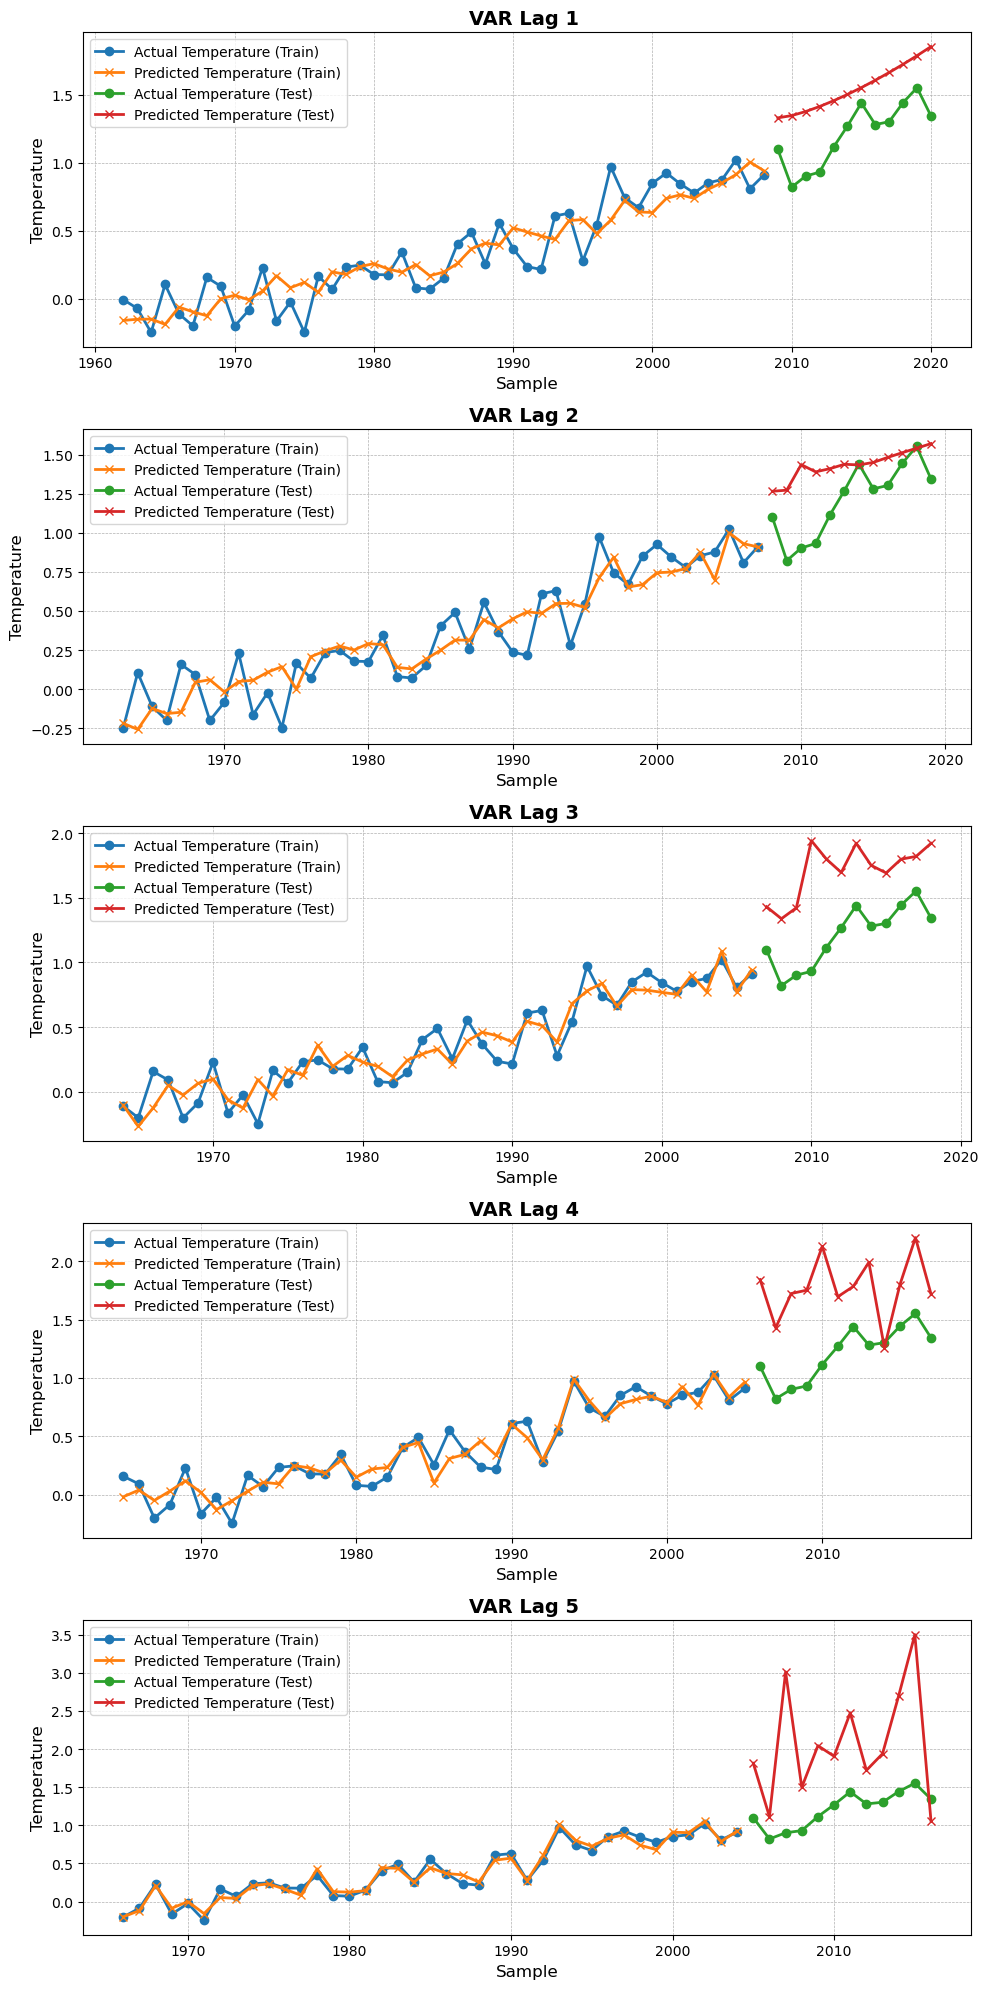

In [11]:
# Call the function with the desired model name
run_algorithm("VAR")


RF Lag 1 - Train MSE: 0.02588, Test MSE: 0.15846, - Train RMSE: 0.16088, Test RMSE: 0.39808 
RF Lag 2 - Train MSE: 0.03870, Test MSE: 0.16827, - Train RMSE: 0.19673, Test RMSE: 0.41021 
RF Lag 3 - Train MSE: 0.03472, Test MSE: 0.17001, - Train RMSE: 0.18633, Test RMSE: 0.41232 
RF Lag 4 - Train MSE: 0.03621, Test MSE: 0.16808, - Train RMSE: 0.19028, Test RMSE: 0.40998 
RF Lag 5 - Train MSE: 0.05549, Test MSE: 0.16577, - Train RMSE: 0.23557, Test RMSE: 0.40715 


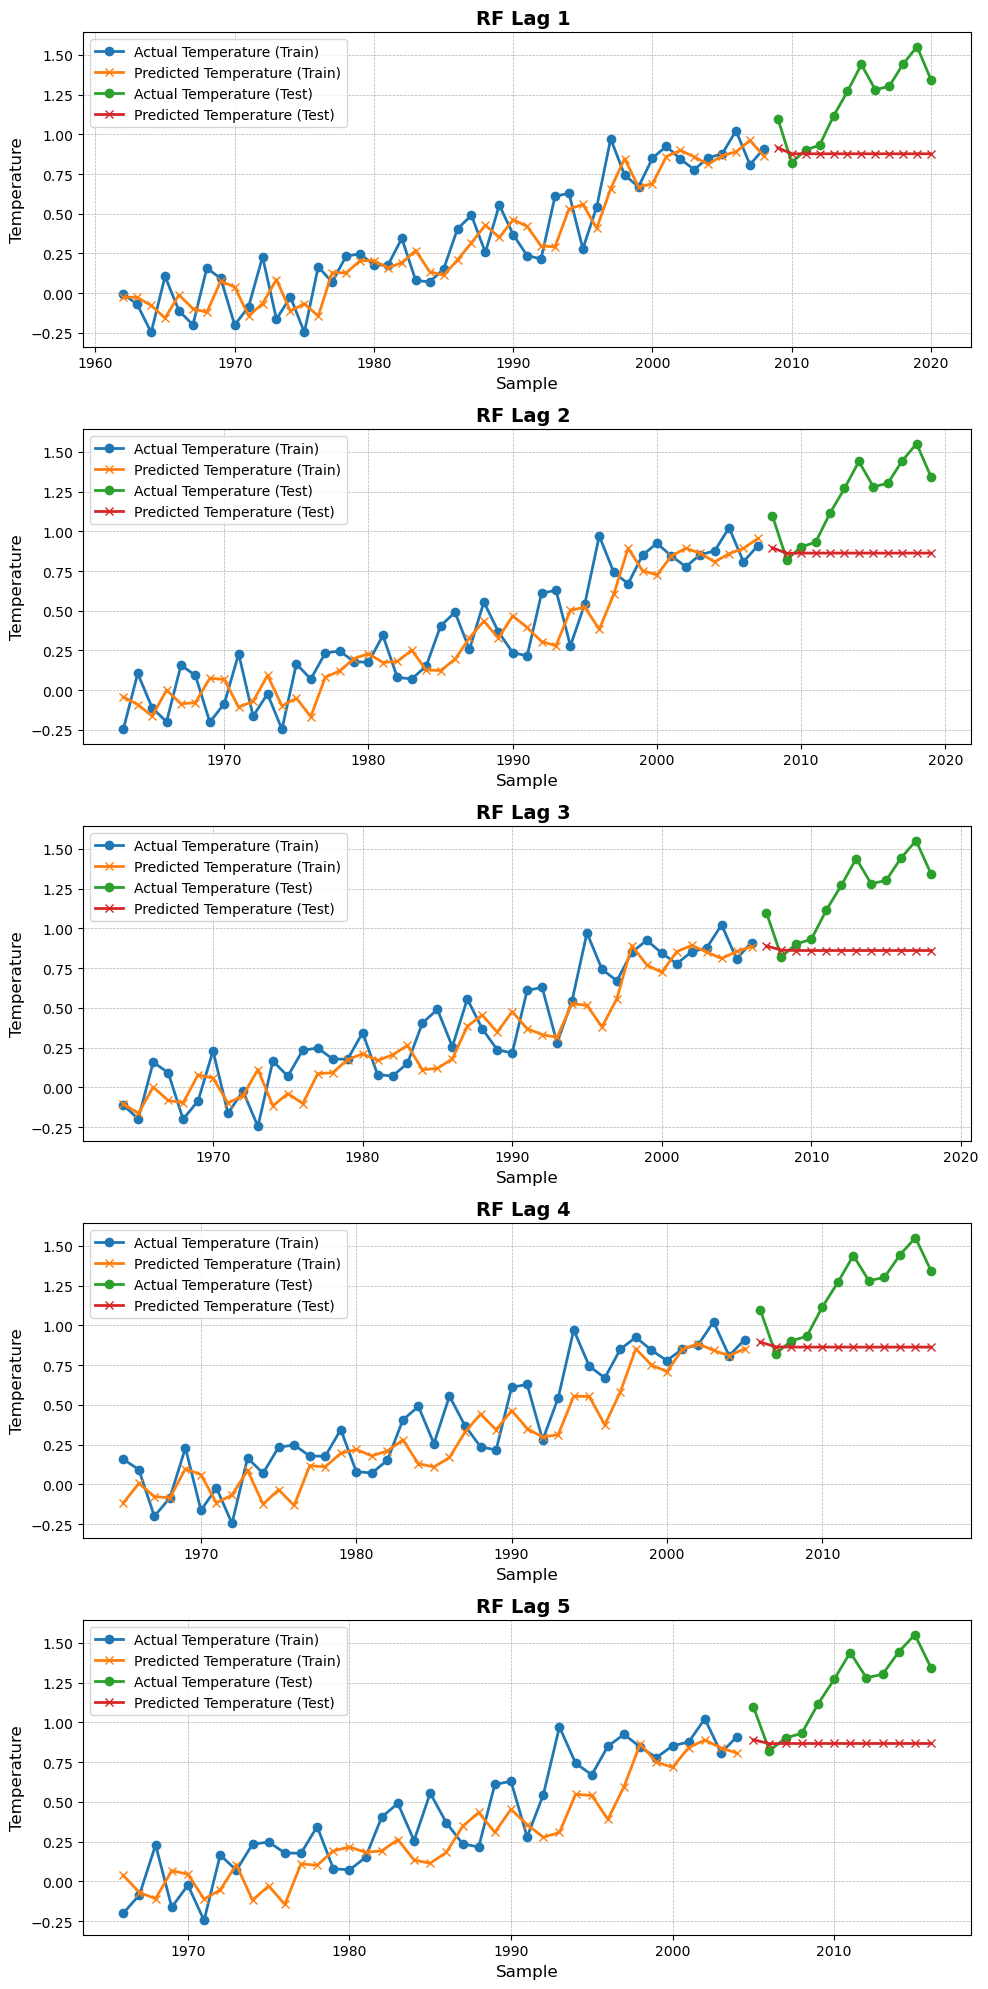

In [12]:
run_algorithm("RF")

SVR Lag 1 - Train MSE: 0.02086, Test MSE: 0.42433, - Train RMSE: 0.14443, Test RMSE: 0.65140 
SVR Lag 2 - Train MSE: 0.02091, Test MSE: 0.49894, - Train RMSE: 0.14462, Test RMSE: 0.70635 
SVR Lag 3 - Train MSE: 0.02093, Test MSE: 0.52349, - Train RMSE: 0.14468, Test RMSE: 0.72353 
SVR Lag 4 - Train MSE: 0.02131, Test MSE: 0.55917, - Train RMSE: 0.14596, Test RMSE: 0.74778 
SVR Lag 5 - Train MSE: 0.02000, Test MSE: 0.57872, - Train RMSE: 0.14141, Test RMSE: 0.76073 


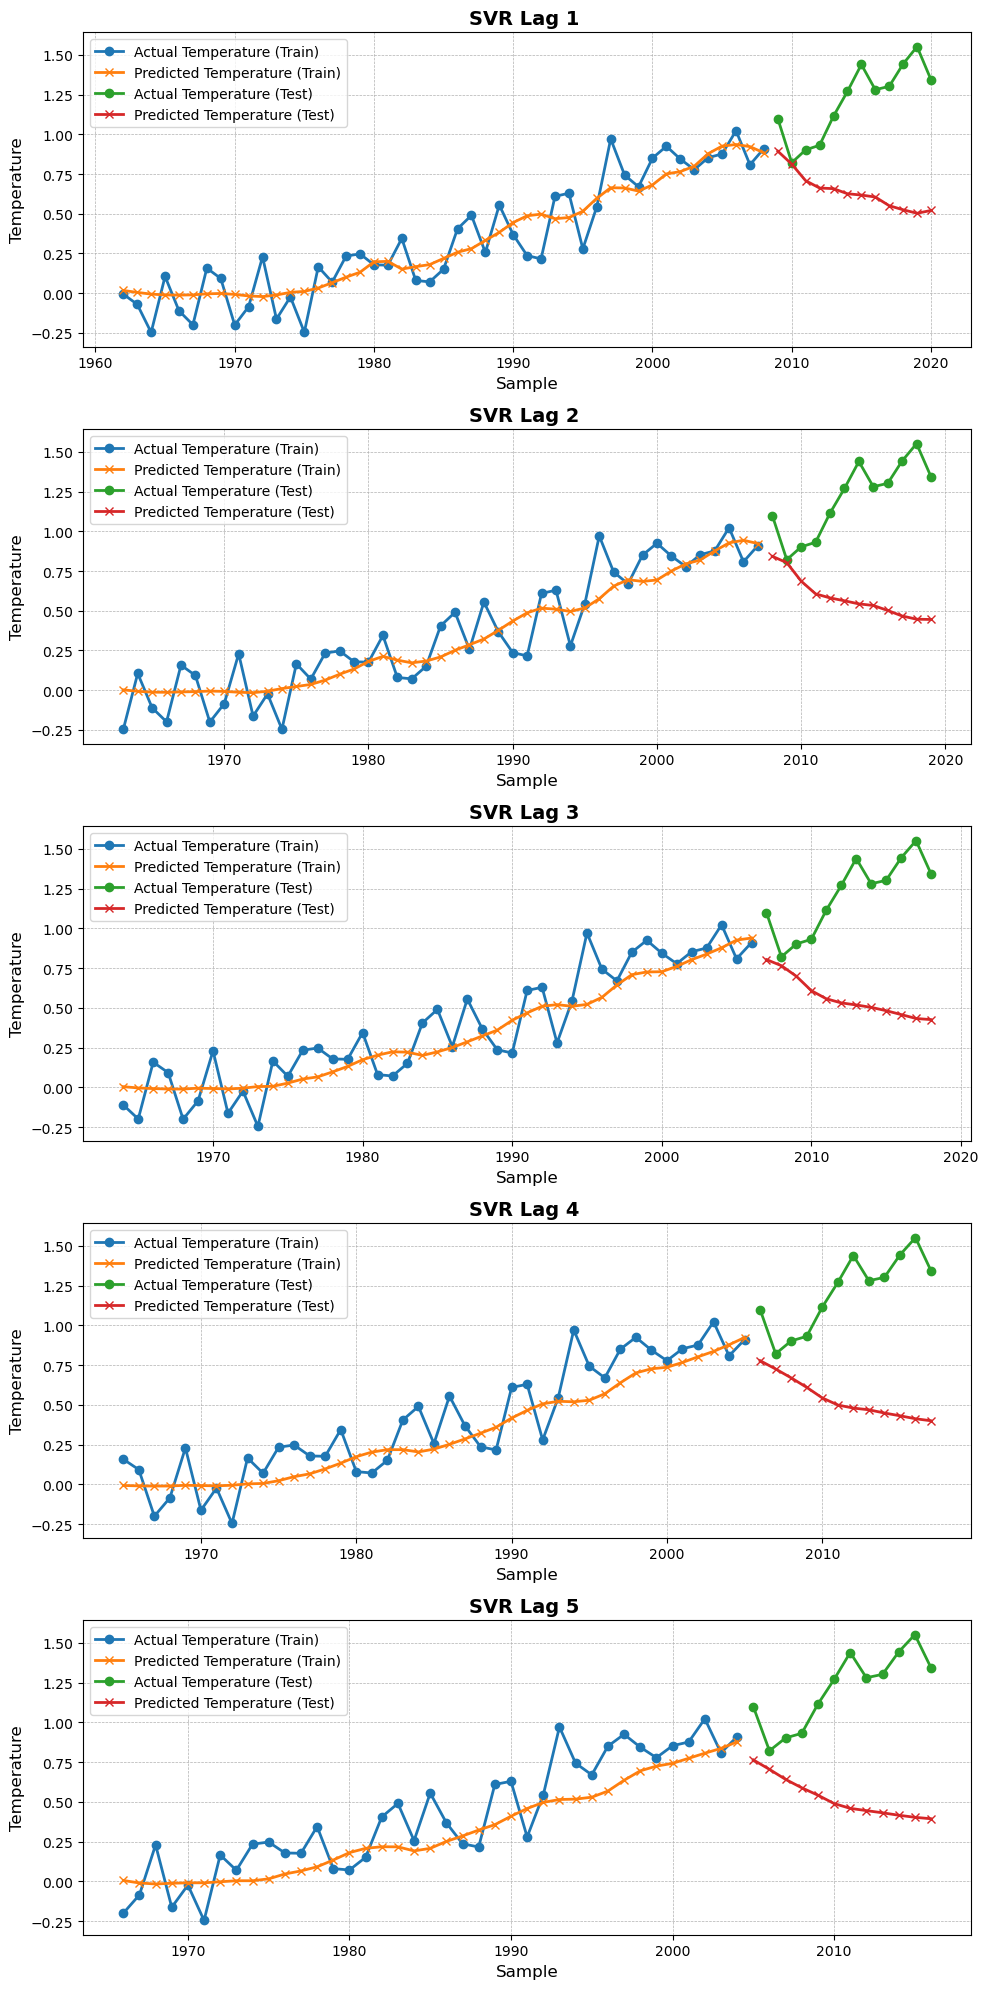

In [13]:
run_algorithm("SVR")

1/1 [==============================] - 0s 37ms/step
LSTM Lag 1 - Train MSE: 0.02863, Test MSE: 0.05161, - Train RMSE: 0.16920, Test RMSE: 0.22717 
1/1 [==============================] - 0s 49ms/step
LSTM Lag 2 - Train MSE: 0.03064, Test MSE: 0.07147, - Train RMSE: 0.17503, Test RMSE: 0.26735 
1/1 [==============================] - 0s 35ms/step
LSTM Lag 3 - Train MSE: 0.03574, Test MSE: 0.05662, - Train RMSE: 0.18906, Test RMSE: 0.23795 
1/1 [==============================] - 0s 80ms/step
LSTM Lag 4 - Train MSE: 0.04303, Test MSE: 0.04291, - Train RMSE: 0.20743, Test RMSE: 0.20715 
1/1 [==============================] - 0s 70ms/step
LSTM Lag 5 - Train MSE: 0.04796, Test MSE: 0.04157, - Train RMSE: 0.21900, Test RMSE: 0.20388 


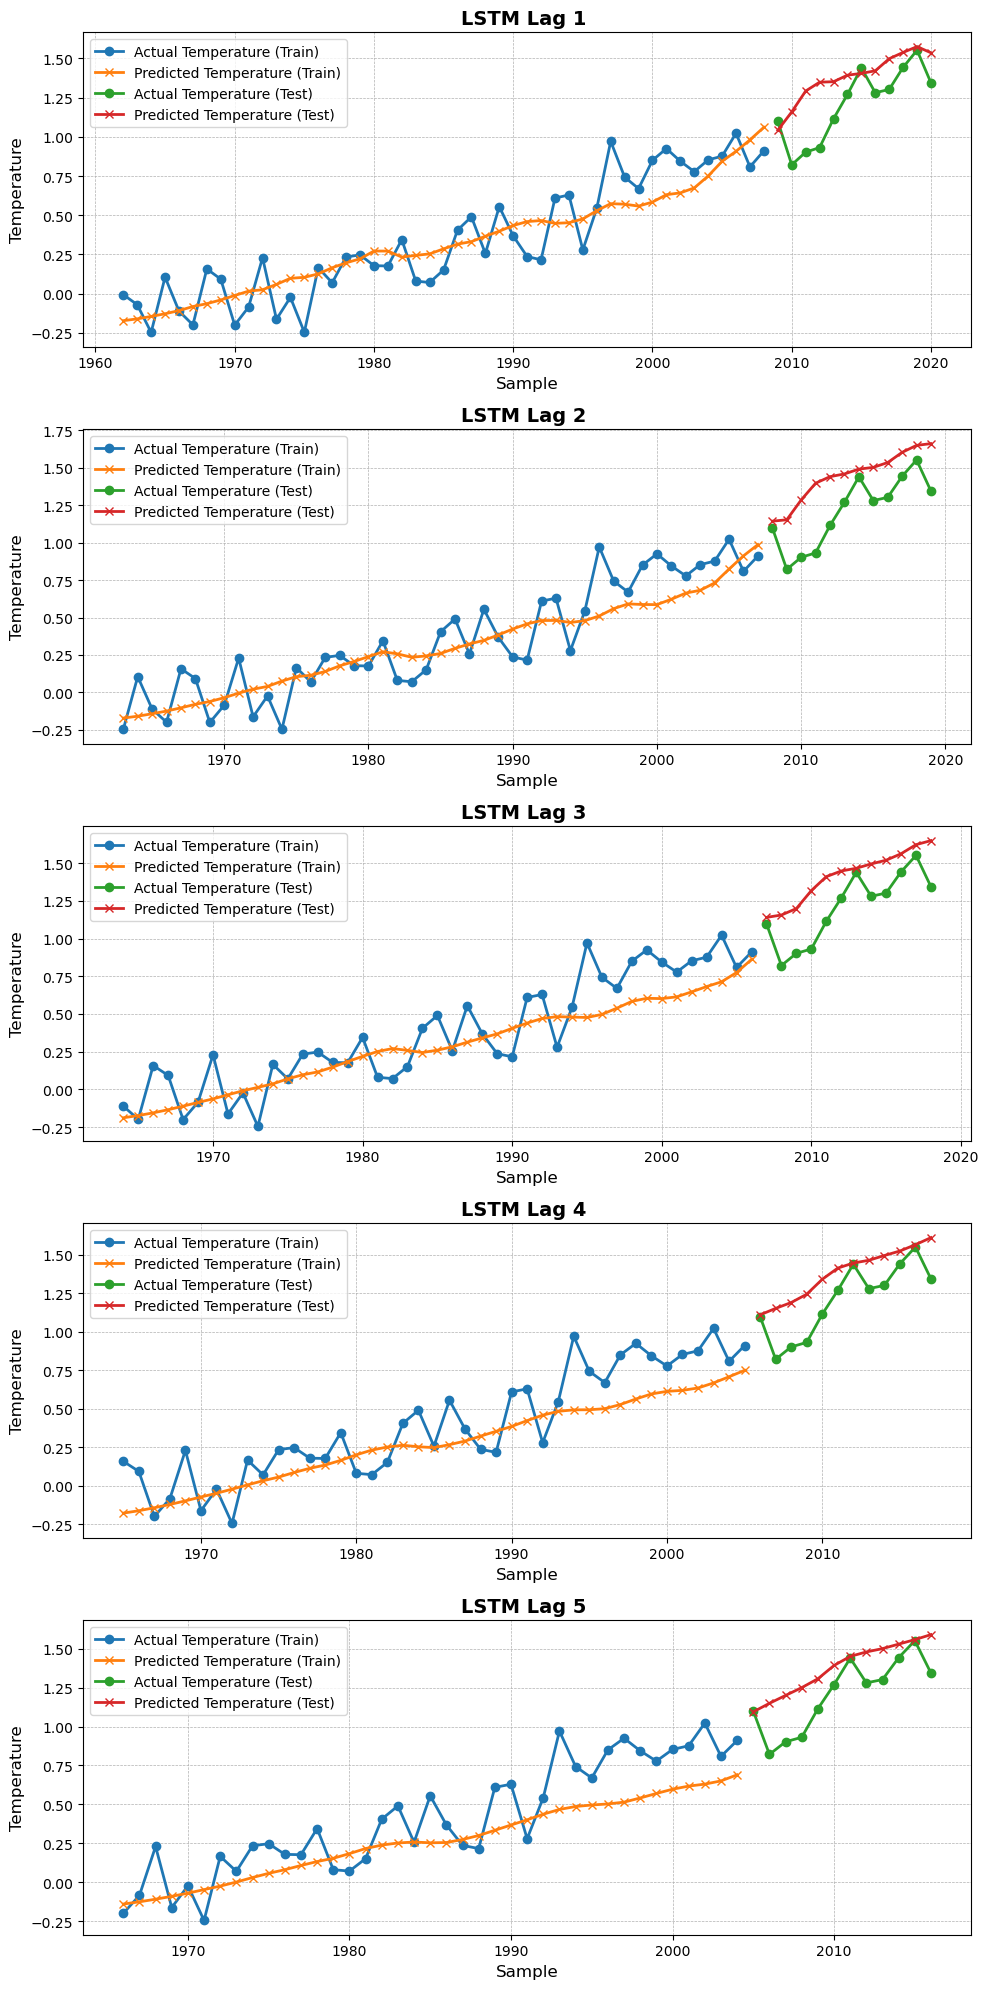

In [14]:
run_algorithm("LSTM")

1/1 [==============================] - 0s 85ms/step
RNN Lag 1 - Train MSE: 0.03341, Test MSE: 0.04611, - Train RMSE: 0.18277, Test RMSE: 0.21473 
1/1 [==============================] - 0s 57ms/step
RNN Lag 2 - Train MSE: 0.03692, Test MSE: 0.03167, - Train RMSE: 0.19215, Test RMSE: 0.17795 
1/1 [==============================] - 0s 59ms/step
RNN Lag 3 - Train MSE: 0.03266, Test MSE: 0.02846, - Train RMSE: 0.18073, Test RMSE: 0.16871 
1/1 [==============================] - 0s 59ms/step
RNN Lag 4 - Train MSE: 0.03674, Test MSE: 0.02222, - Train RMSE: 0.19168, Test RMSE: 0.14908 
1/1 [==============================] - 0s 63ms/step
RNN Lag 5 - Train MSE: 0.03959, Test MSE: 0.03393, - Train RMSE: 0.19897, Test RMSE: 0.18420 


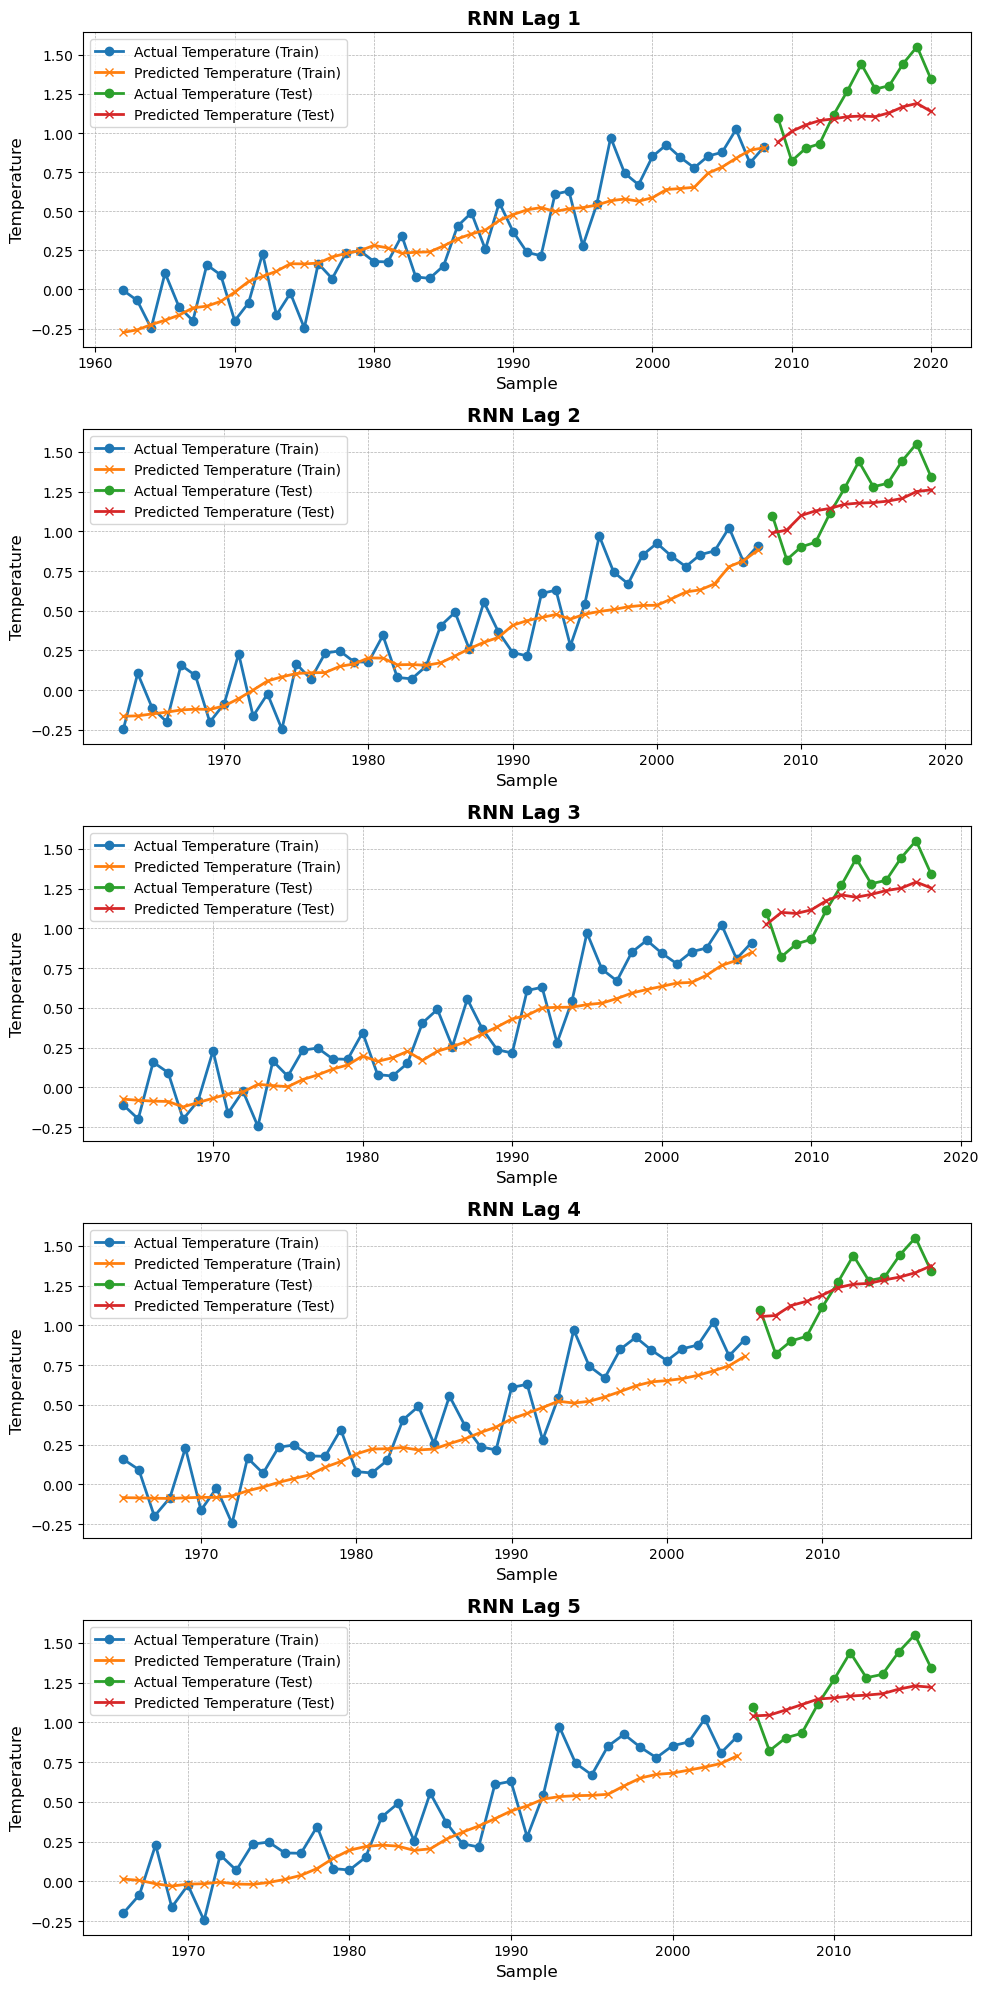

In [15]:
run_algorithm("RNN")

In [16]:
MODELS_DICT

{'VAR': {'models': [<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x20bf3dc7ac0>,
  'mse': [0.1335796987689799,
   0.07975436409718949,
   0.28755566157230794,
   0.3985038023473591,
   1.1448326373299822],
  'rmse': [0.36548556574641894,
   0.2824081516125012,
   0.5362421669099773,
   0.631271575747997,
   1.069968521653783],
  'lags': [1, 2, 3, 4, 5]},
 'RF': {'models': [RandomForestRegressor(),
   RandomForestRegressor(),
   RandomForestRegressor(),
   RandomForestRegressor(),
   RandomForestRegressor()],
  'mse': [0.15846398841132112,
   0.16827430793738,
   0.17000699617377935,
   0.16808425826942971,
   0.16577305825788674],
  'rmse': [0.3980753551921057,
   0.4102125155786693,
   0.41231904658138135,
   0.40998080231814477,
   0.40715237719788244],
  'lags': [1, 2, 3, 4, 5]},
 'LSTM': {'models': [<keras.engine.sequential.Sequential at 0x20bf44a3b50>,
  'mse': [0.051605764585843115,
   0.07147405599484043,
   0.05662175697095392,
   0.04291216379509268,
   0.04156727

In [21]:
pd.DataFrame.from_dict(MODELS_DICT, orient='index')

models   
VAR   [<statsmodels.tsa.vector_ar.var_model.VARResul...  \
RF    [(DecisionTreeRegressor(max_features=1.0, rand...   
LSTM  [<keras.engine.sequential.Sequential object at...   
RNN   [<keras.engine.sequential.Sequential object at...   
SVR                 [SVR(), SVR(), SVR(), SVR(), SVR()]   

                                                    mse   
VAR   [0.1335796987689799, 0.07975436409718949, 0.28...  \
RF    [0.15846398841132112, 0.16827430793738, 0.1700...   
LSTM  [0.051605764585843115, 0.07147405599484043, 0....   
RNN   [0.04610802385910709, 0.03166657284651371, 0.0...   
SVR   [0.424325228930661, 0.49893711450962125, 0.523...   

                                                   rmse             lags  
VAR   [0.36548556574641894, 0.2824081516125012, 0.53...  [1, 2, 3, 4, 5]  
RF    [0.3980753551921057, 0.4102125155786693, 0.412...  [1, 2, 3, 4, 5]  
LSTM  [0.2271690220647241, 0.26734632220182203, 0.23...  [1, 2, 3, 4, 5]  
RNN   [0.21472779014162813, 0.1779510405884543, 0.16...  [1, 2, 3, 4, 5]  
SVR   [0.6514025091528747, 0.7063548078052709, 0.723...  [1, 2, 3, 4, 5]

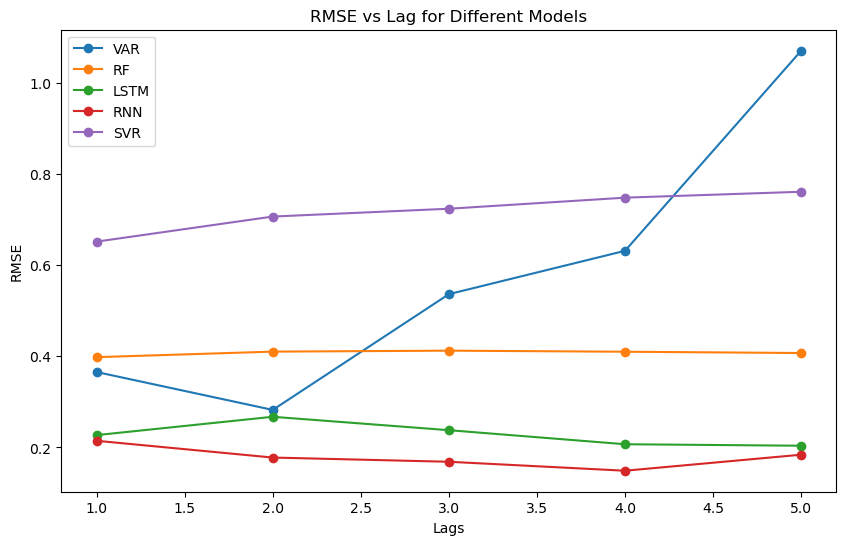

In [23]:
df = pd.DataFrame.from_dict(MODELS_DICT, orient='index')
# Create a plot for RMSE vs Lag for each model
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model_data in df.iterrows():
    ax.plot(model_data['lags'], model_data['rmse'], marker='o', label=model_name)

ax.set_xlabel('Lags')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Lag for Different Models')
ax.legend()

plt.show()

In [ ]:
def forward_model(model, generated_data_scaled):
    fig, ax = plt.subplots(len(LAGS), 1, figsize=(10, 20))
    predictions = {}

    for idx, lag in enumerate(LAGS):
        X_generated = np.zeros((len(generated_data_scaled) - lag, lag * generated_data_scaled.shape[1]))

        for i in range(lag, len(generated_data_scaled)):
            X_generated[i - lag] = generated_data_scaled[i - lag:i].flatten()

        if model == "VAR":
            results = MODELS_DICT['VAR'][lag - 1]
            lagged_endog_generated = np.concatenate((X_generated[-lag:], np.zeros((lag, 1))), axis=1)
            y_pred_generated = results.forecast(y=lagged_endog_generated, steps=len(X_generated))[:, -1]
        elif model == "LSTM":
            X_generated_seq = X_generated.reshape(X_generated.shape[0], lag, generated_data_scaled.shape[1])
            model_lstm = MODELS_DICT['LSTM'][lag - 1]
            y_pred_generated = model_lstm.predict(X_generated_seq)
        elif model == "RNN":
            X_generated_seq = X_generated.reshape(X_generated.shape[0], lag, generated_data_scaled.shape[1])
            model_rnn = MODELS_DICT['RNN'][lag - 1]
            y_pred_generated = model_rnn.predict(X_generated_seq)

        predictions[str(lag)] = y_pred_generated

        # Plot the years and predictions for different lags
        years_generated = np.arange(2021 + lag, 2051)
        ax[idx].plot(years_generated, predictions[str(lag)], label=f'Predicted Temperature (Lag {lag})', linewidth=2, marker="x")
        ax[idx].set_xlabel('Year', fontsize=12)
        ax[idx].set_ylabel('Temperature', fontsize=12)
        ax[idx].set_title(f"{model} Lag {lag}", fontsize=14, fontweight='bold')
        ax[idx].legend(loc='upper left', fontsize=10)
        ax[idx].tick_params(axis='both', which='major', labelsize=10)
        ax[idx].grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

In [ ]:
# Define the initial emission values for 2021 for CO2, N2O, and CH4
initial_co2 = data.iloc[-1, :].values[2]  
initial_n2o = data.iloc[-1, :].values[4]
initial_ch4 = data.iloc[-1, :].values[3]

# Define emission increase rates for each gas (for demonstration purposes)
co2_increase_rate = 2.0  
n2o_increase_rate = 1.5  
ch4_increase_rate = 0.5  

# Generate emission scenarios from 2021 to 2050
years = range(2021, 2051)
co2_emissions_scenario1 = [initial_co2 + co2_increase_rate * (year - 2021) for year in years]
n2o_emissions_scenario1 = [initial_n2o + n2o_increase_rate * (year - 2021) for year in years]
ch4_emissions_scenario1 = [initial_ch4 + ch4_increase_rate * (year - 2021) for year in years]


In [ ]:
scenerio1 = pd.DataFrame({
    'Year': years,
    'Annual CO2 Emissions': co2_emissions_scenario1,
    'Annual MH4 Emissions': ch4_emissions_scenario1,
    'Annual NiO Emissions': n2o_emissions_scenario1,
})

In [ ]:
scenerio1_X = scenerio1[features].copy()

In [ ]:
scenerio1_X_scaled = scaler.fit_transform(scenerio1_X)

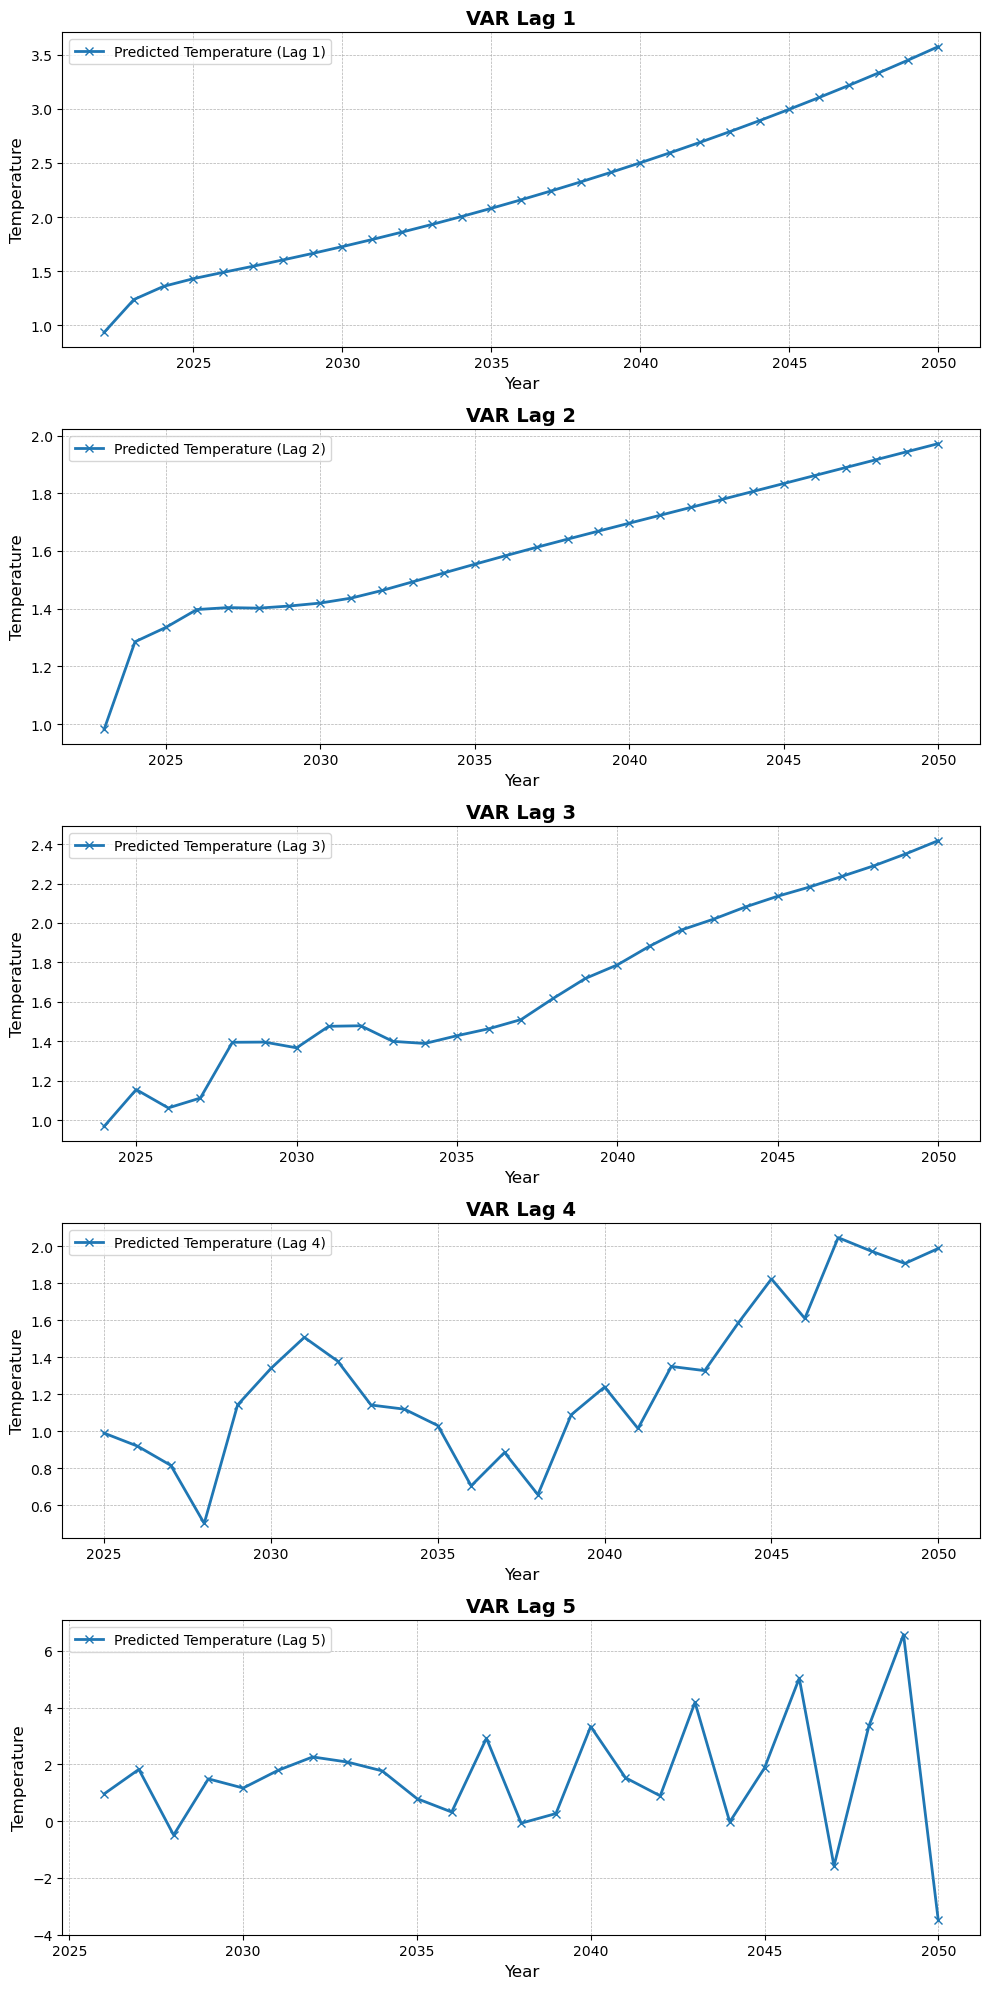

In [ ]:

forward_model("VAR", scenerio1_X_scaled)


1/1 [==============================] - 0s 37ms/step


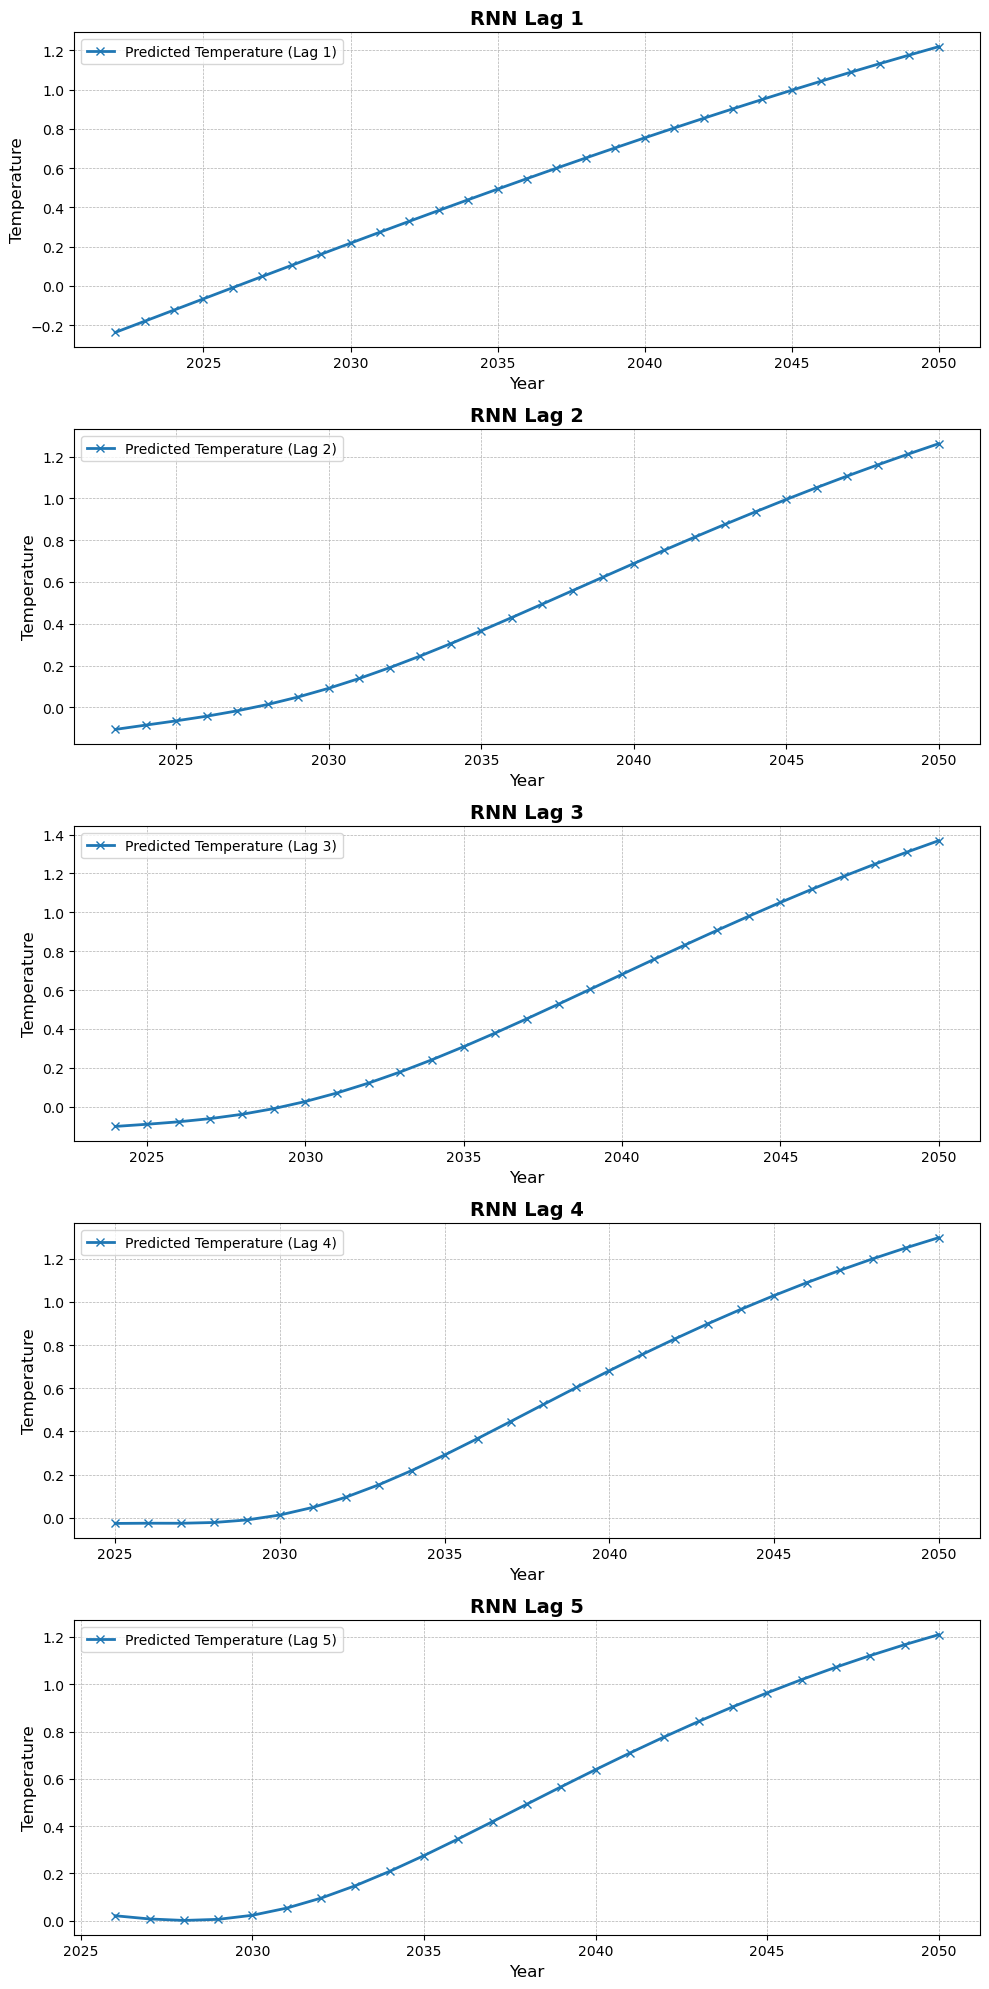

In [ ]:

forward_model("RNN", scenerio1_X_scaled)


1/1 [==============================] - 0s 44ms/step


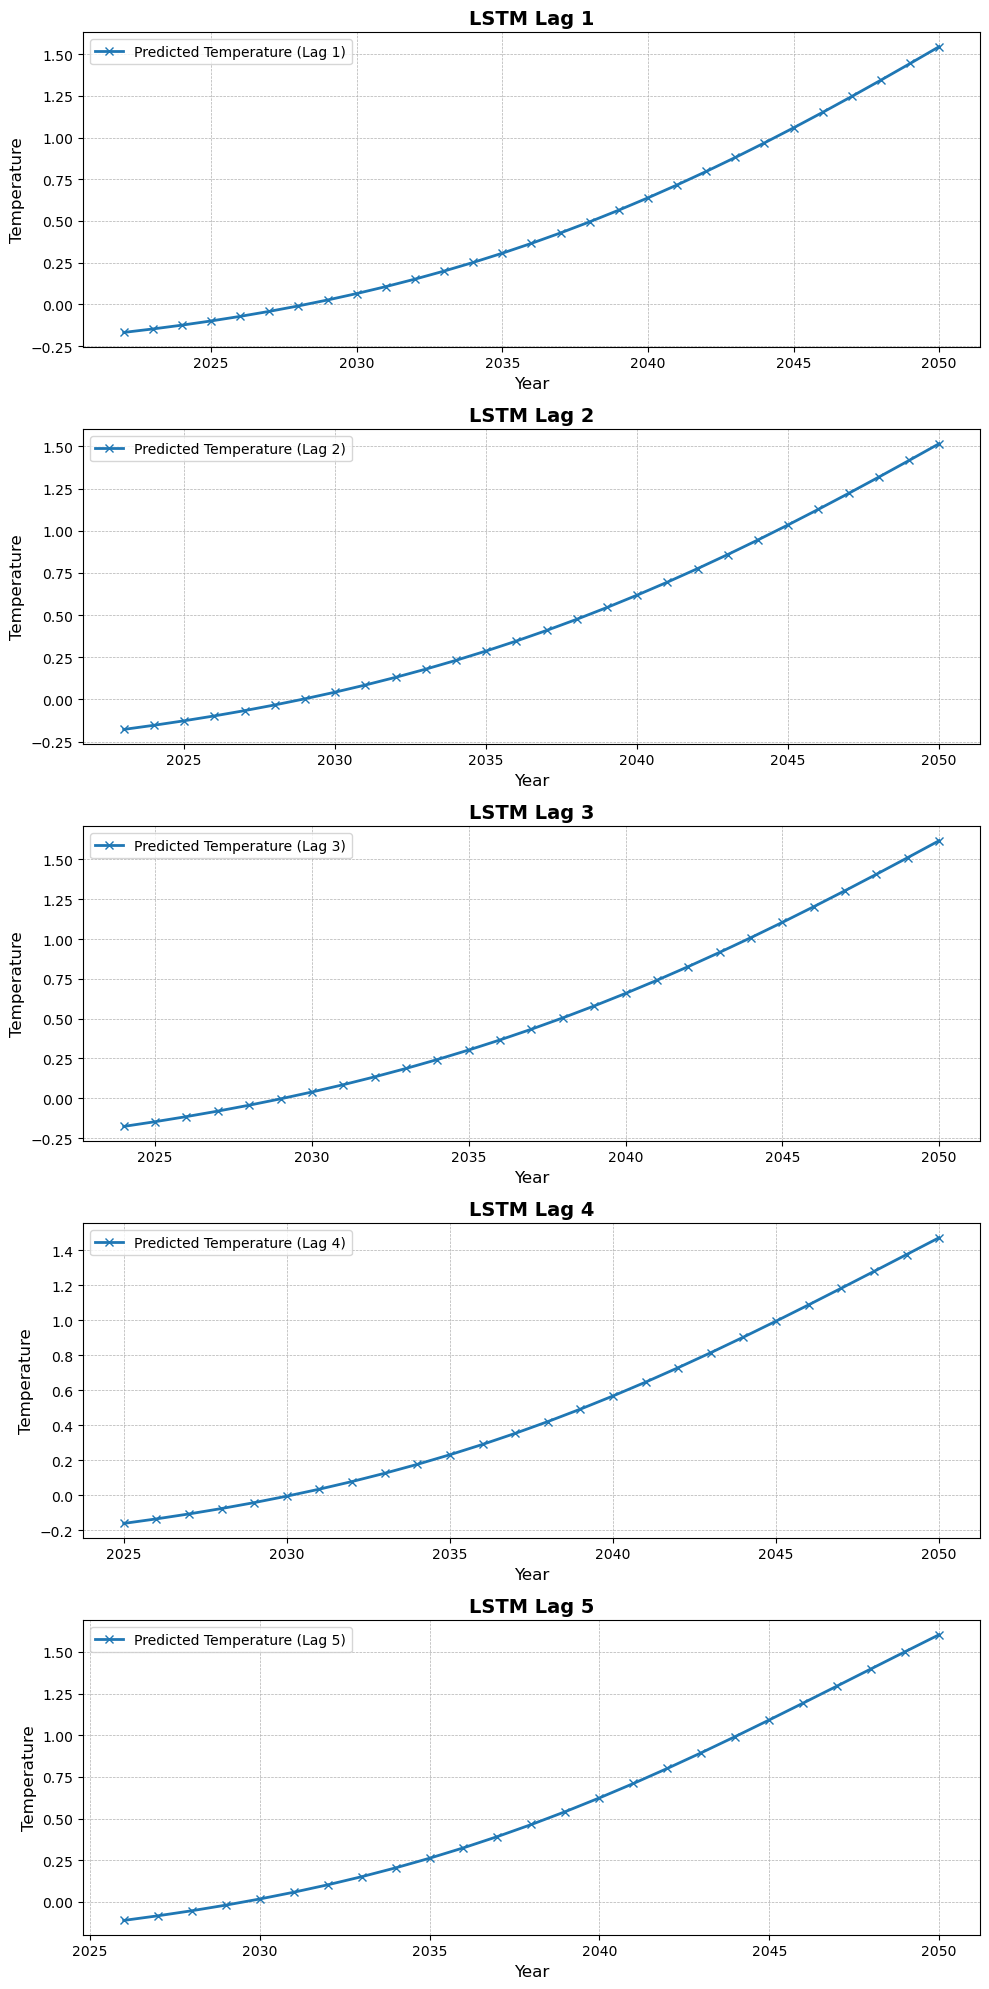

In [ ]:

forward_model("LSTM", scenerio1_X_scaled)


In [ ]:
# Generate emission scenarios from 2021 to 2050
years = range(2021, 2051)
co2_emissions_scenario2 = [initial_co2 - co2_increase_rate * (year - 2021) for year in years]
n2o_emissions_scenario2 = [initial_n2o - n2o_increase_rate * (year - 2021) for year in years]
ch4_emissions_scenario2 = [initial_ch4 - ch4_increase_rate * (year - 2021) for year in years]


scenerio2 = pd.DataFrame({
    'Year': years,
    'Annual CO2 Emissions': co2_emissions_scenario2,
    'Annual MH4 Emissions': ch4_emissions_scenario2,
    'Annual NiO Emissions': n2o_emissions_scenario2,
})

scenerio2_X = scenerio2[features].copy()

scenerio2_X_scaled = scaler.fit_transform(scenerio2_X)

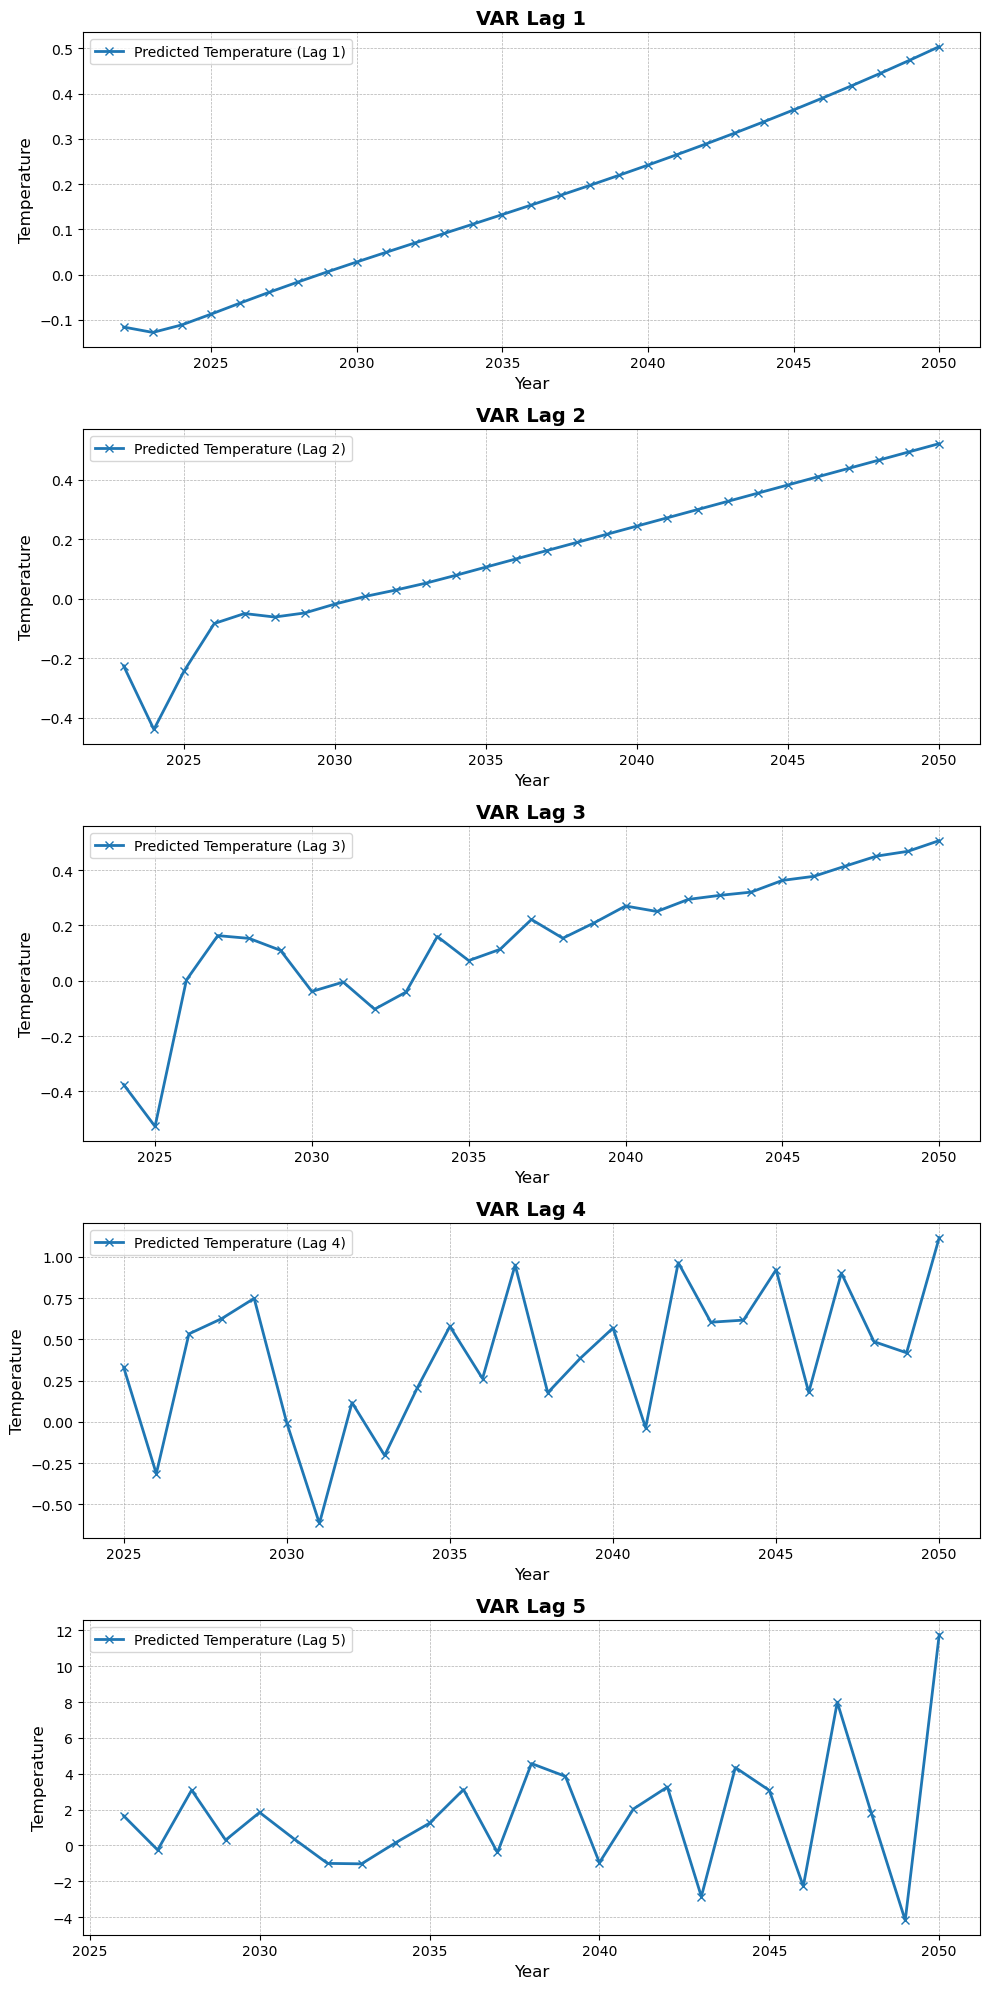

In [ ]:
forward_model('VAR', scenerio2_X_scaled)

1/1 [==============================] - 0s 30ms/step


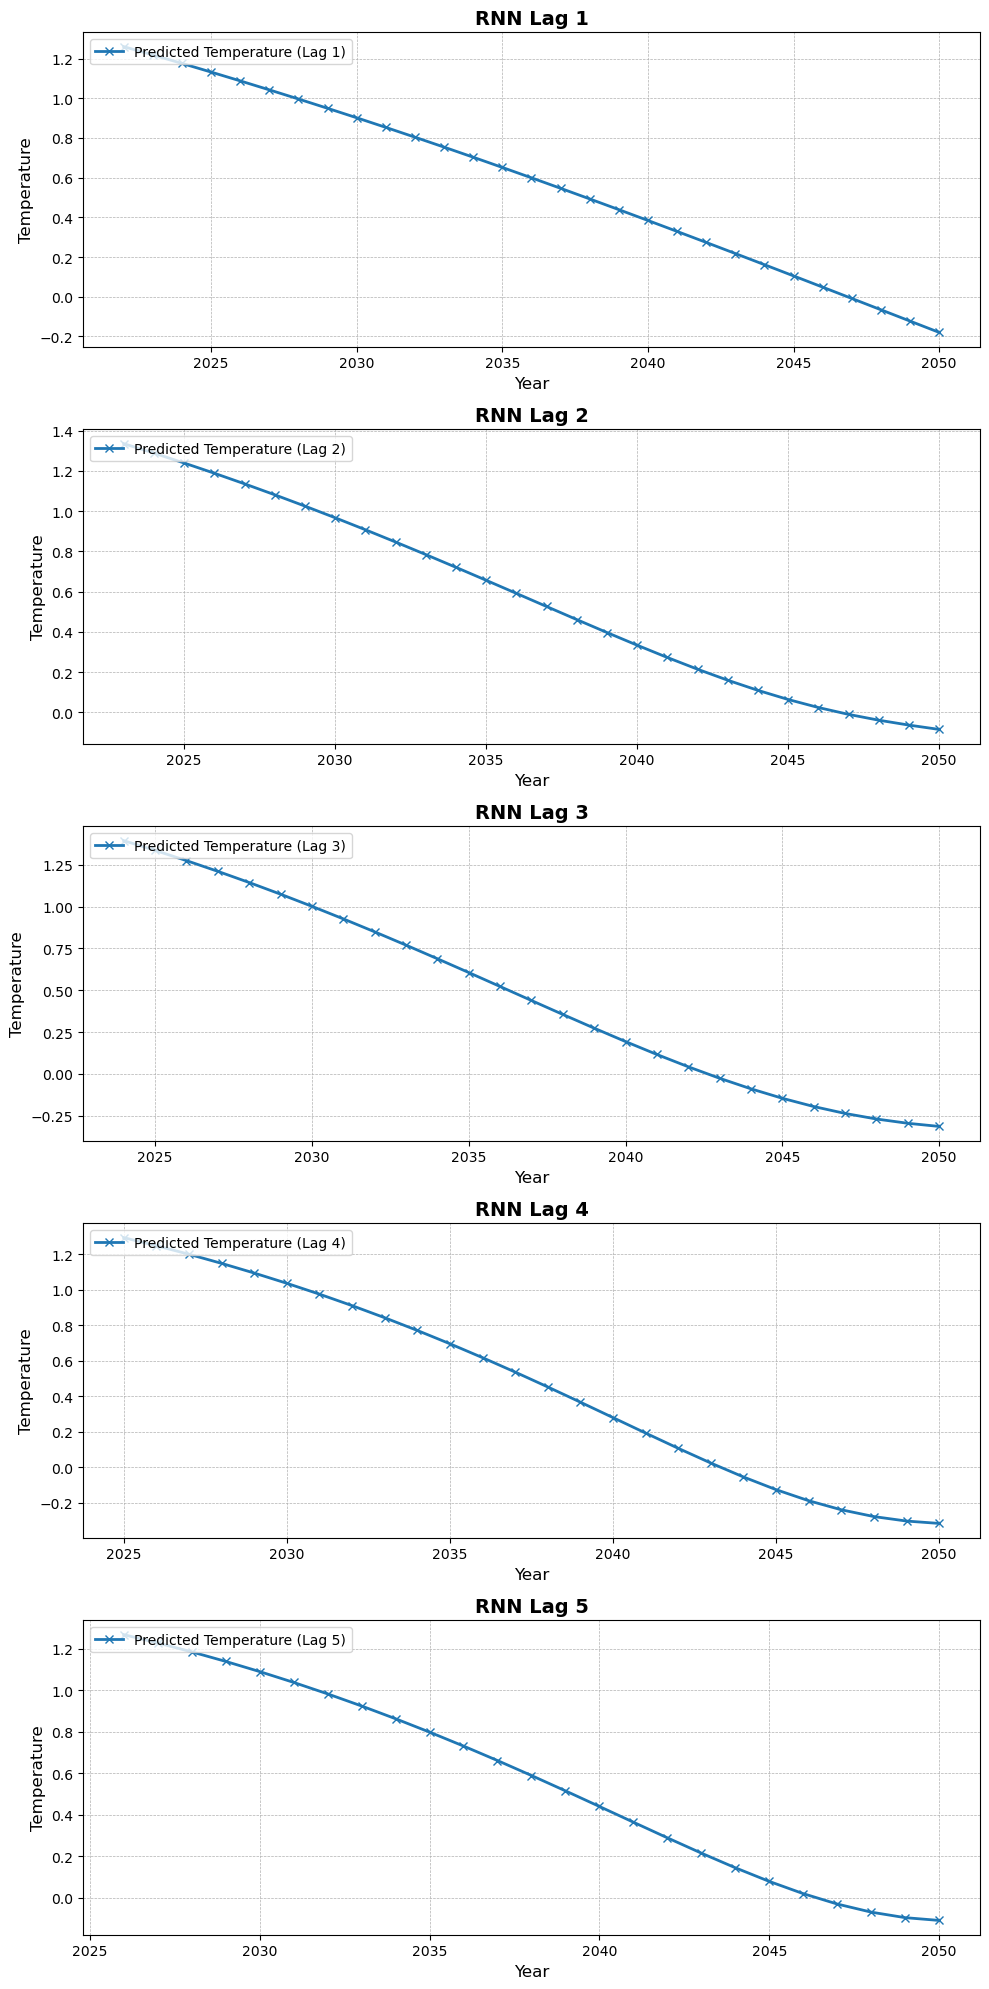

In [ ]:
forward_model('RNN', scenerio2_X_scaled)

1/1 [==============================] - 0s 33ms/step


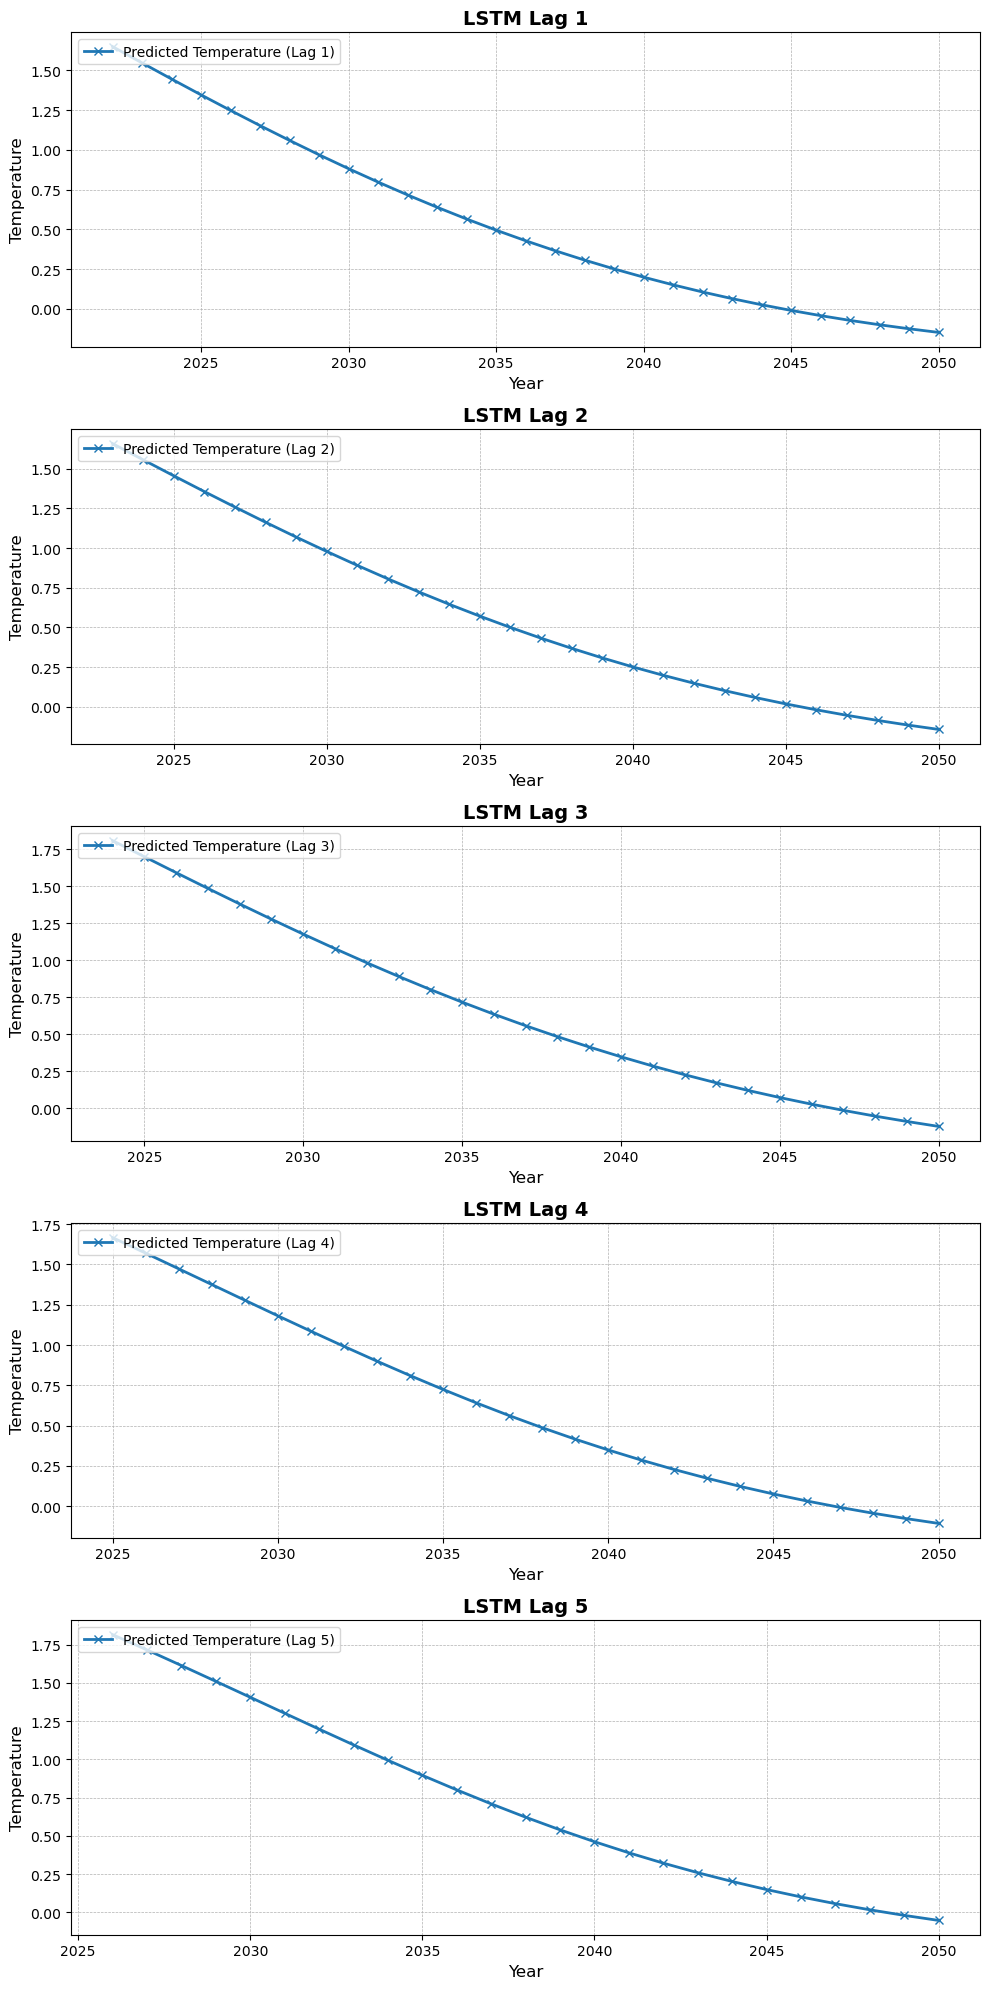

In [ ]:
forward_model('LSTM', scenerio2_X_scaled)

In [ ]:
# Generate emission scenarios from 2021 to 2050
years = range(2021, 2051)
co2_emissions_scenario3 = [initial_co2 for year in years]
n2o_emissions_scenario3 = [initial_n2o for year in years]
ch4_emissions_scenario3 = [initial_ch4 for year in years]


scenerio3 = pd.DataFrame({
    'Year': years,
    'Annual CO2 Emissions': co2_emissions_scenario3,
    'Annual MH4 Emissions': ch4_emissions_scenario3,
    'Annual NiO Emissions': n2o_emissions_scenario3,
})

scenerio3_X = scenerio3[features].copy()

scenerio3_X_scaled = scaler.fit_transform(scenerio3_X)

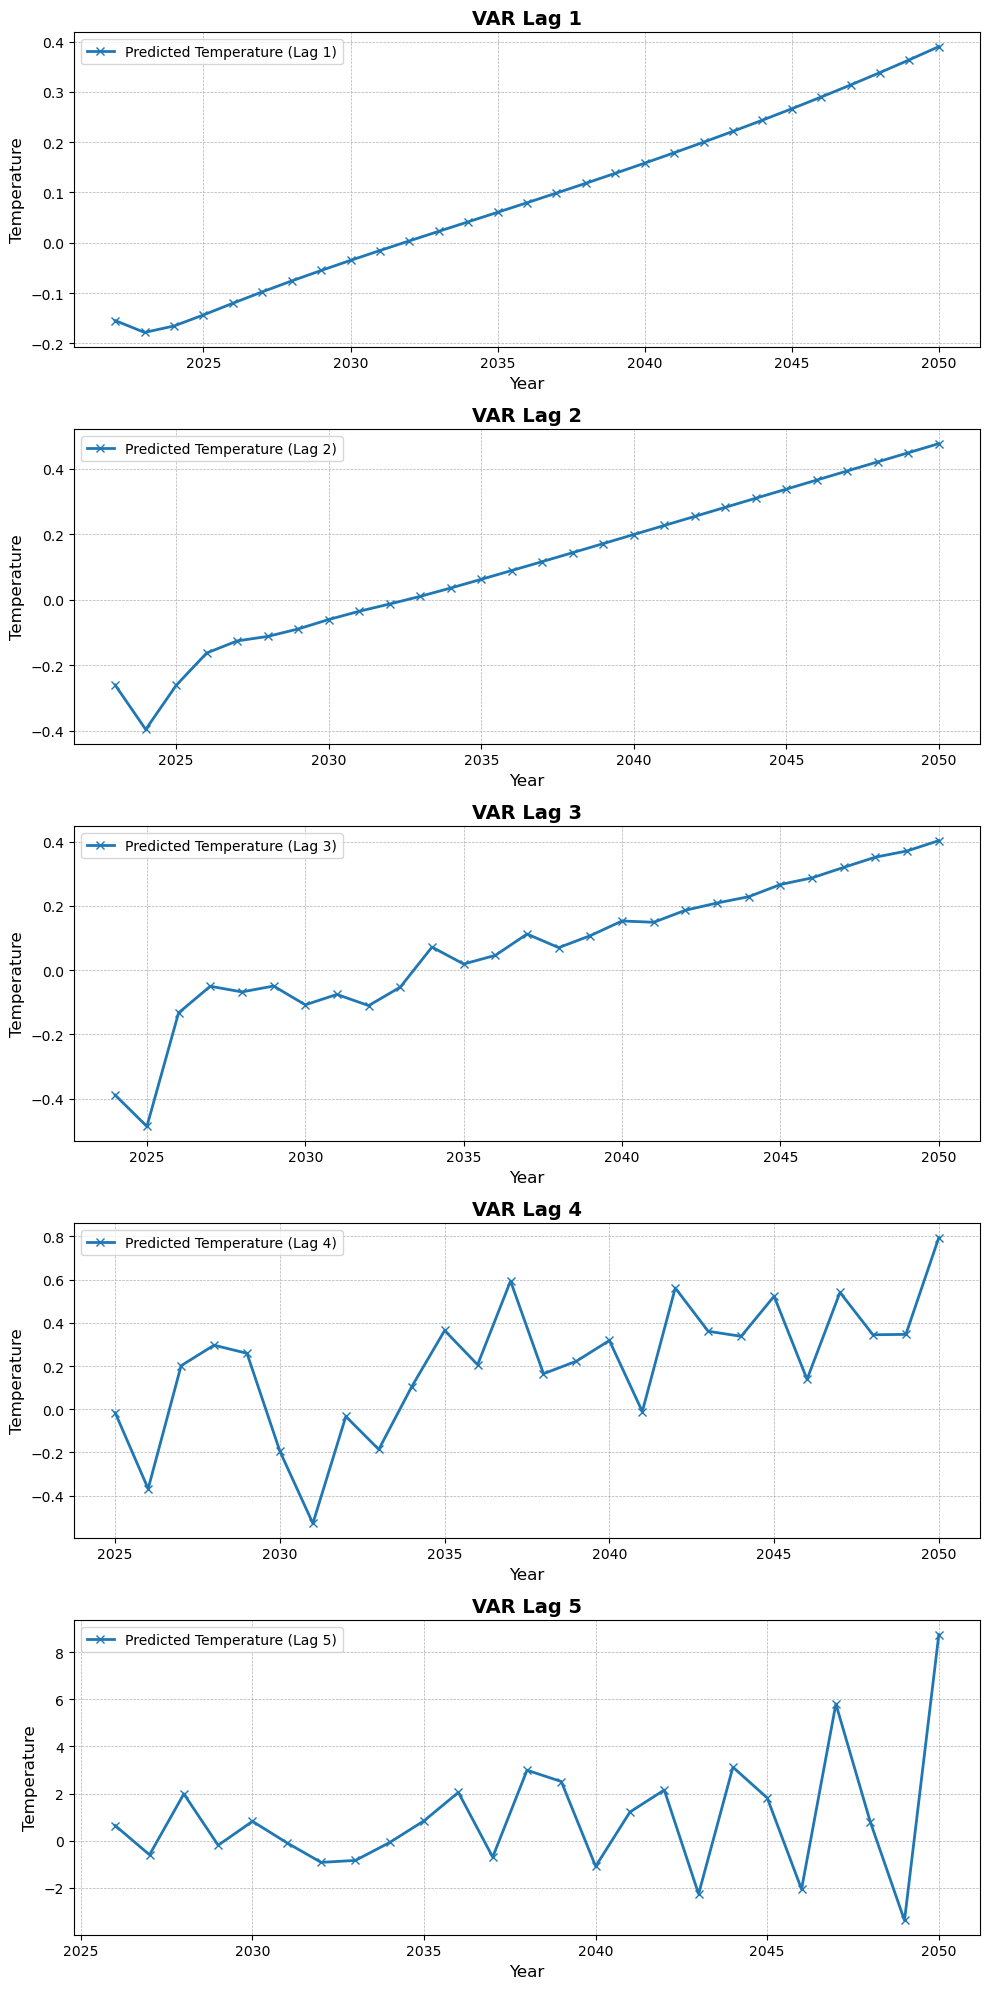

In [ ]:
forward_model('VAR', scenerio3_X_scaled)

1/1 [==============================] - 0s 30ms/step


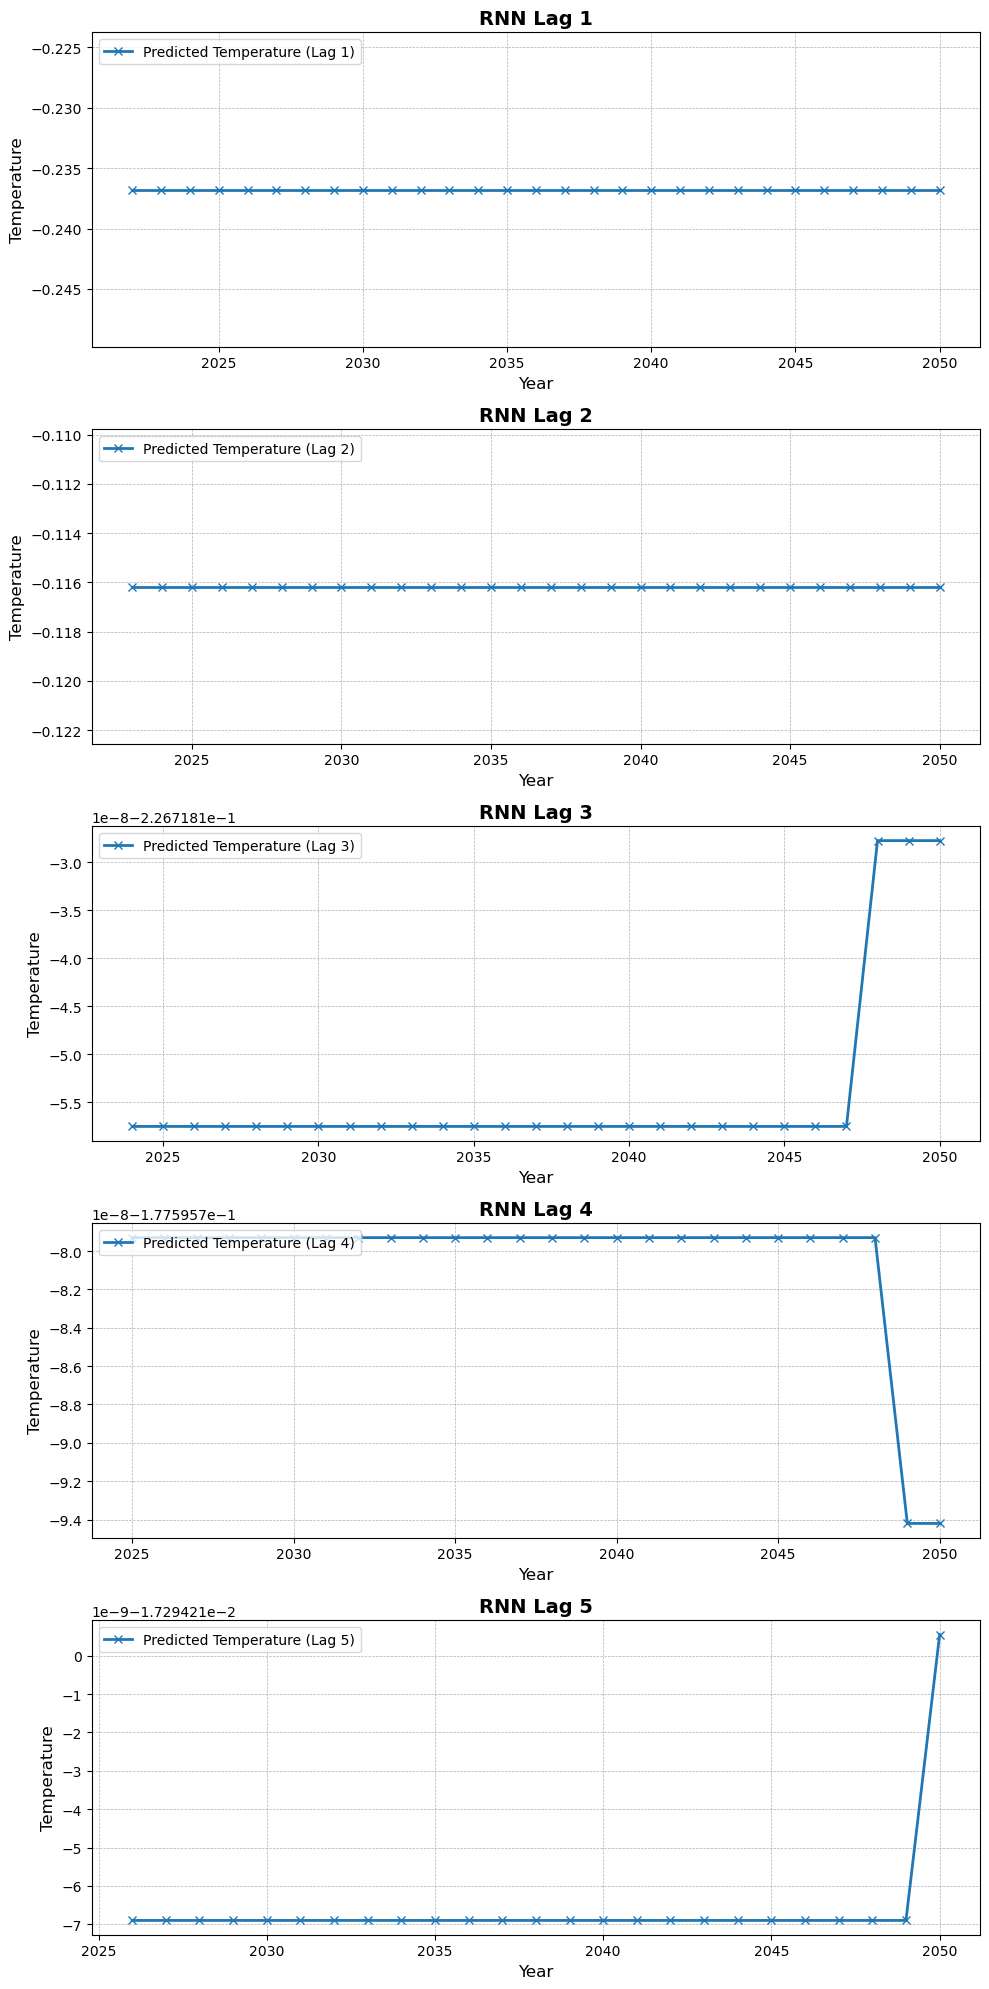

In [ ]:
forward_model('RNN', scenerio3_X_scaled)

1/1 [==============================] - 0s 33ms/step


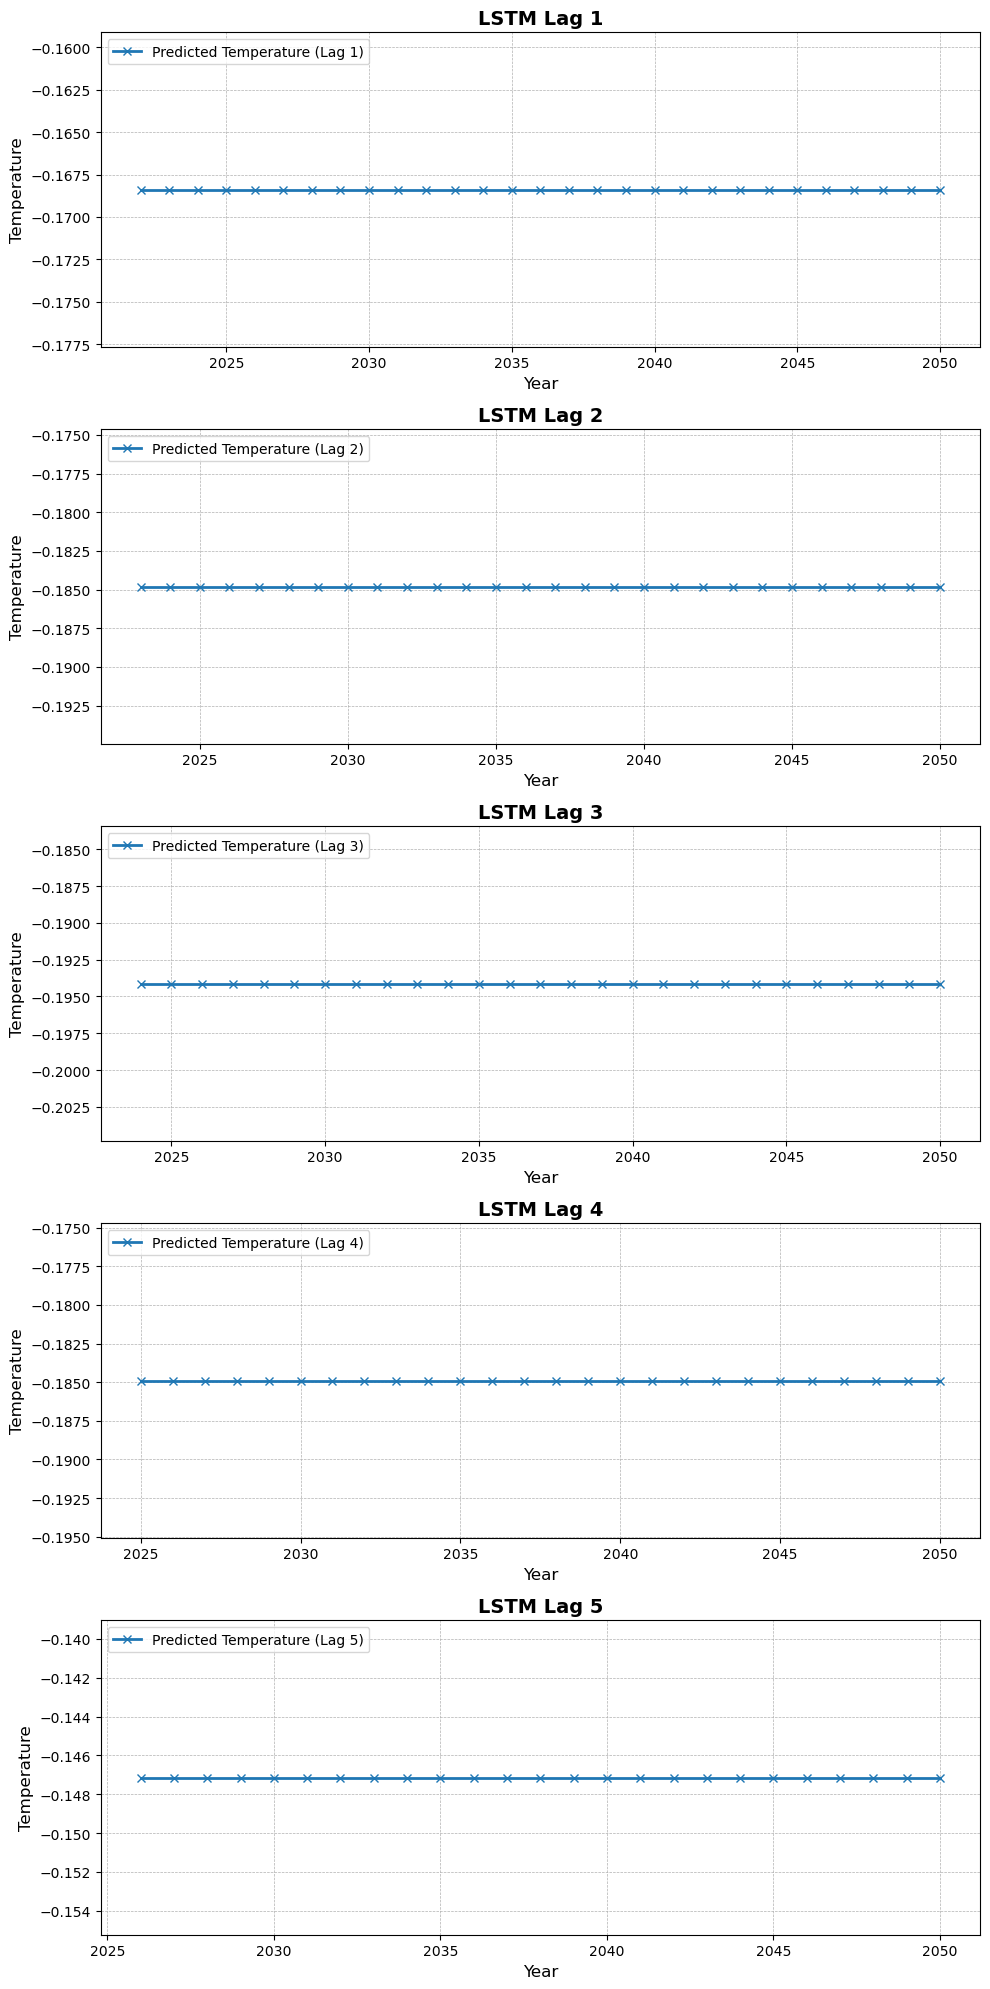

In [ ]:
forward_model('LSTM', scenerio3_X_scaled)